In [12]:
# !pip install pyspark

In [13]:
import os
import sys
import pandas as pd
print(sys.executable)

# Better view for charts
# High quality image
%config InlineBackend.figure_format = 'svg'


/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/.venv/bin/python


In [14]:
# 0. Create Spark Session
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import regexp_extract, col, when, avg, lag, abs as spark_abs
from pyspark.sql.functions import col, log1p, abs as spark_abs

from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

# Updated train and test split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split


spark = SparkSession.builder \
    .appName("UNSW_Preprocessing") \
    .getOrCreate()

# 1. Load Data & Drop Nan (Make sure NUSW... .csv and jupiter file on same dir)
df = spark.read.csv("../Group_Assignment_Database/UNSW_NB15_training-set.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

# save features in UNSW-NB15_features.csv
features = spark.read.csv("UNSW-NB15_features.csv", header=True, inferSchema=True)
features_only = features.select('Name')
features_only.printSchema()
features_only.show(5)

features_list = (
    features_only
    .select("Name")
    .rdd
    .flatMap(lambda x: x)
    .collect()
)

print("\nfeatures_list: ", features_list)

# 1-1. Visualize and Understand data

from pyspark.ml.feature import RFormula

# Feature selection
feature_candidates = set(features_list)
actual_df_cols = set(df.columns)

label_col = "label"

root
 |-- id: integer (nullable = true)
 |-- dur: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- state: string (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- sbytes: integer (nullable = true)
 |-- dbytes: integer (nullable = true)
 |-- rate: double (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sload: double (nullable = true)
 |-- dload: double (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- sinpkt: double (nullable = true)
 |-- dinpkt: double (nullable = true)
 |-- sjit: double (nullable = true)
 |-- djit: double (nullable = true)
 |-- swin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- tcprtt: double (nullable = true)
 |-- synack: double (nullable = true)
 |-- ackdat: double (nullable 

In [15]:
def load_and_prep_data():
    # train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    # test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'\

    # Juwon's Local file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'

    # 1. Load both datasets
    print("Loading data...")
    df_train_orig = pd.read_csv(train_path)
    df_test_orig = pd.read_csv(test_path)

    # 2. Combine them
    df_full = pd.concat([df_train_orig, df_test_orig], axis=0).reset_index(drop=True)

    # 3. Preprocessing (Label Encoding)
    le = LabelEncoder()
    categorical_cols = ['proto', 'service', 'state', 'attack_cat']
    for col in categorical_cols:
        df_full[col] = le.fit_transform(df_full[col].astype(str))

    # 4. Define Features and Target
    # We use 'label' for stratification to maintain class balance
    drop_cols = ['label', 'id', 'attack_cat']
    X = df_full.drop(drop_cols, axis=1)
    y = df_full['label']

    print(f"Features used for training ({len(X.columns)} total):")
    print(list(X.columns))
    print("-" * 50)

    # 5. Stratified Split: Train (70%) and Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 6. Split Temp into Validation (15%) and Test (15%)
    # 0.5 * 30% = 15%
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"Data Loaded and Split:")
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Unpack the validation set
X_train, y_train, X_val, y_val, X_test, y_test = load_and_prep_data()

def check_distributions(y_train, y_val, y_test):
    sets = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
    for name, set_data in sets.items():
        counts = set_data.value_counts(normalize=True) * 100
        print(f"{name} Distribution: Normal: {counts[0]:.2f}%, Attack: {counts[1]:.2f}%")

check_distributions(y_train, y_val, y_test)

Loading data...
Features used for training (42 total):
['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
--------------------------------------------------
Data Loaded and Split:
Train: (180371, 42), Val: (38651, 42), Test: (38651, 42)
Train Distribution: Normal: 36.09%, Attack: 63.91%
Validation Distribution: Normal: 36.09%, Attack: 63.91%
Test Distribution: Normal: 36.09%, Attack: 63.91%


## Add new columns

In [16]:
from pyspark.sql.functions import isnan, when, count

def missing_value_report(df):
    return df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c)
        for c in df.columns
    ])

missing_value_report(df).show(truncate=False)


+---+---+-----+-------+-----+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
|id |dur|proto|service|state|spkts|dpkts|sbytes|dbytes|rate|sttl|dttl|sload|dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+---+-----+-------+-----+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+-----

## Feature Engineering

In [17]:
# Add new columns pkt_ratio and ttl_gap
spark_train_df = df \
    .withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1)) \
    .withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))

spark_test_df = df \
    .withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1)) \
    .withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))


In [18]:

# Exclude_columns
# trans_depth(only zeros)
# response_body_len(only zeros)
excluded = {"attack_cat", "id"}

selected_cols = [c for c in X_train.columns if c not in excluded]

X_train, y_train, X_val, y_val, X_test, y_test

# select dataframe with only selected columns
df_filtered = df.select(*selected_cols)

# Extract Numeric Columns
from pyspark.sql.types import NumericType


numeric_cols = [
    f.name for f in df_filtered.schema.fields
    if isinstance(f.dataType, NumericType) and f.name != "label"
]

print("Numeric columns:", numeric_cols)


# only filter the any nulls detected columns
null_summary = df_filtered.select([
    count(
        when(col(c).isNull() | isnan(col(c)), c)
    ).alias(c)
    for c in numeric_cols
])

# Show all data
null_summary.show(truncate=False)



Numeric columns: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
+---+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+
|dur|spkts|dpkts|sbytes|dbytes|rate|sttl|dttl|sload|dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct

## Visualization

### Distributions

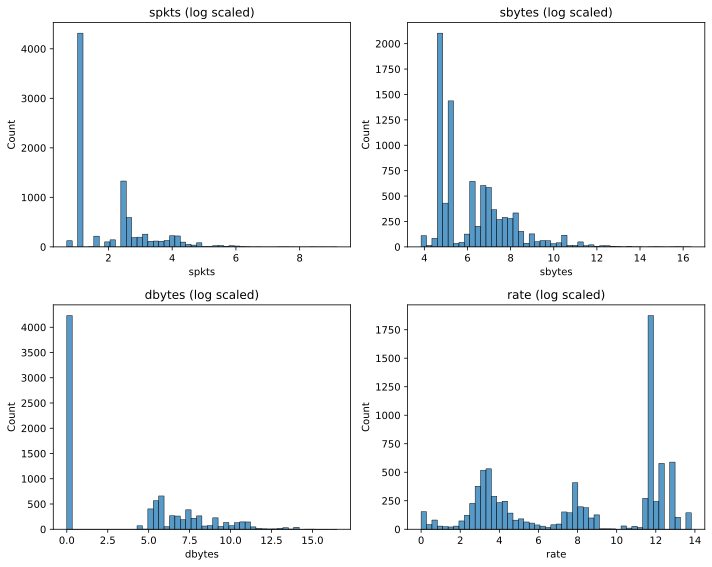

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sample_pd = spark_train_df.select(
    "spkts", "sbytes", "dbytes", "rate"
).sample(fraction=0.05, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(10,8))

sns.histplot(np.log1p(sample_pd["spkts"]), bins=50, ax=axes[0,0])
axes[0,0].set_title("spkts (log scaled)")

sns.histplot(np.log1p(sample_pd["sbytes"]), bins=50, ax=axes[0,1])
axes[0,1].set_title("sbytes (log scaled)")

sns.histplot(np.log1p(sample_pd["dbytes"]), bins=50, ax=axes[1,0])
axes[1,0].set_title("dbytes (log scaled)")

sns.histplot(np.log1p(sample_pd["rate"]), bins=50, ax=axes[1,1])
axes[1,1].set_title("rate (log scaled)")

plt.tight_layout()
plt.show()


### Correlation Visulization

In [20]:
df_filtered.columns
y_train.columns


AttributeError: 'Series' object has no attribute 'columns'

/var/folders/vy/xvrzy34d5r3dcmcbf4jj5sz80000gn/T/ipykernel_42755/826765011.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


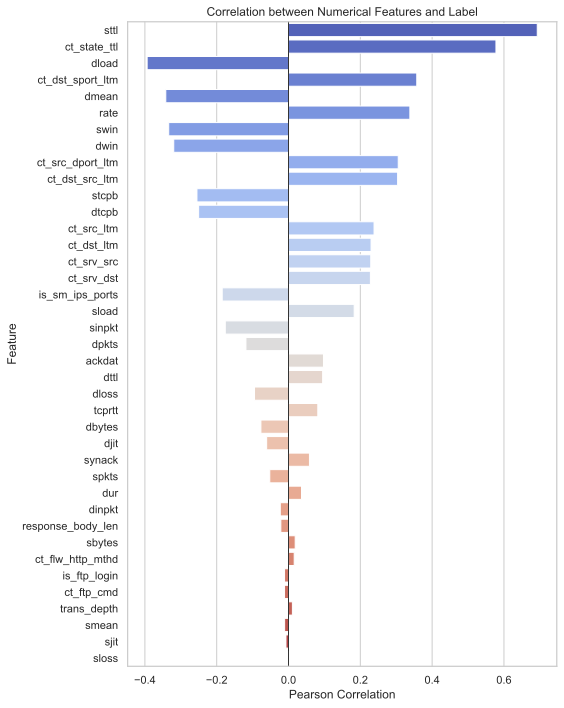

In [22]:


# Correlation Check to identify unnecessary columns
# Calculate corelation of each labels
corr_rows = []

for c in numeric_cols:
    corr_val =df.stat.corr(c, "label") # => 여기가 문제
    corr_rows.append((c, corr_val))

# convert to spark DF
corr_df = spark.createDataFrame(
    corr_rows,
    ["feature", "correlation"]
)

# convert to pandas DF
corr_pd = (
    corr_df
    .toPandas()
    .sort_values(by="correlation", key=abs, ascending=False)
)


sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 10))
sns.barplot(
    data=corr_pd,
    x="correlation",
    y="feature",
    palette="coolwarm"
)

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Correlation between Numerical Features and Label")
plt.xlabel("Pearson Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Outlier Visualization

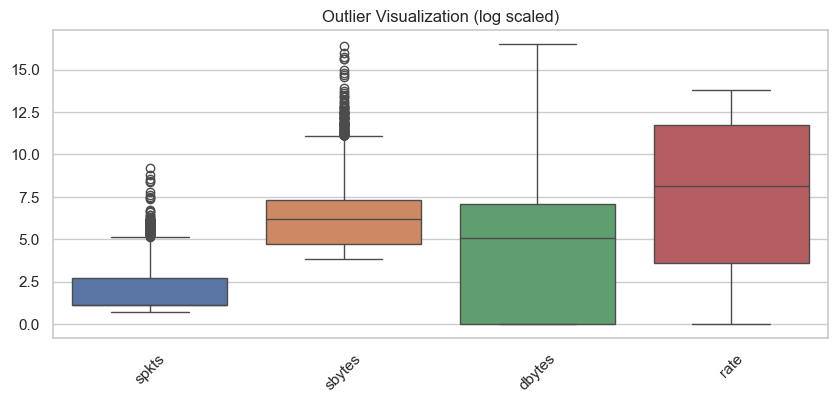

In [ ]:
box_cols = ["spkts", "sbytes", "dbytes", "rate"]

box_pd = spark_train_df.select(box_cols) \
    .sample(0.05, seed=42) \
    .toPandas()

plt.figure(figsize=(10,4))
sns.boxplot(data=np.log1p(box_pd))
plt.xticks(rotation=45)
plt.title("Outlier Visualization (log scaled)")
plt.show()


### Label Distribution

+-----+------+
|label| count|
+-----+------+
|    0| 56000|
|    1|119341|
+-----+------+



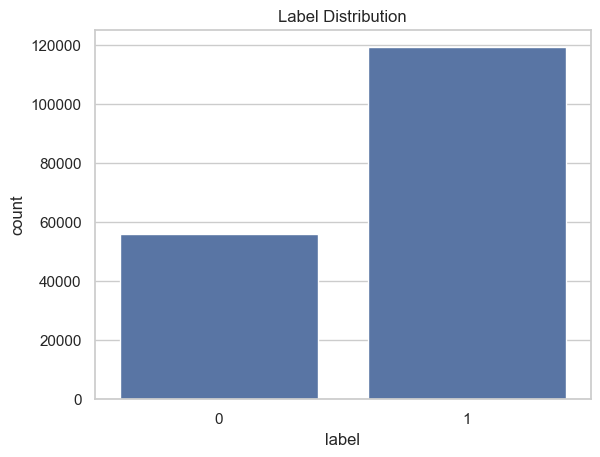

In [ ]:
label_count_df = spark_train_df.groupBy("label").count()
label_count_df.show()

label_pd = label_count_df.toPandas()

sns.barplot(x="label", y="count", data=label_pd)
plt.title("Label Distribution")
plt.show()


### Correlation heatmap

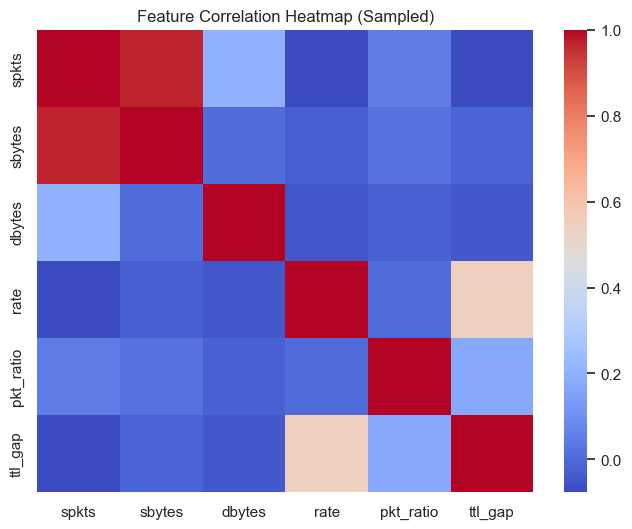

In [ ]:
corr_cols = ["spkts", "sbytes", "dbytes", "rate", "pkt_ratio", "ttl_gap"]

corr_pd = spark_train_df.select(corr_cols) \
    .sample(0.05, seed=42) \
    .toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(corr_pd.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap (Sampled)")
plt.show()


In [ ]:
# Generate list format will columns that are not in excluded
valid_features = [
    c for c in feature_candidates
    if c in actual_df_cols and c != label_col and c not in excluded
]

print("\nValid features:", valid_features)

# features_only has col "Name" which has a list of columns,
# Search for the colname and if exist in actual df for formula(RFormula)
interaction_terms = []

# "color": categorical col, "value": numerical col
if "color" in valid_features:
    for v in ["value1", "value2"]:
        if v in valid_features:
            interaction_terms.append(f"color:{v}")
            
# RF string generation (Excluding categorical cols)
base_terms = [c for c in valid_features if c != "color"]

# formula right hand side
formula_rhs = base_terms + interaction_terms
formula = f"{label_col} ~ " + " + ".join(formula_rhs)

print("\nGenerated R formula: ")
print(formula)


# Able to use R language
supervised = RFormula(formula=formula)
fittedRF = supervised.fit(df_filtered)
preparedDF = fittedRF.transform(df_filtered)

print("\n\npreparedDF:")
preparedDF.show()



Valid features: ['is_sm_ips_ports', 'tcprtt', 'ct_flw_http_mthd', 'service', 'ct_srv_dst', 'dur', 'synack', 'ct_dst_ltm', 'state', 'dttl', 'is_ftp_login', 'dbytes', 'sbytes', 'dloss', 'dwin', 'stcpb', 'dtcpb', 'sloss', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_state_ttl', 'swin', 'ct_ftp_cmd', 'sttl', 'ackdat', 'trans_depth', 'ct_dst_sport_ltm', 'proto', 'ct_srv_src']

Generated R formula: 
label ~ is_sm_ips_ports + tcprtt + ct_flw_http_mthd + service + ct_srv_dst + dur + synack + ct_dst_ltm + state + dttl + is_ftp_login + dbytes + sbytes + dloss + dwin + stcpb + dtcpb + sloss + ct_src_dport_ltm + ct_dst_src_ltm + ct_state_ttl + swin + ct_ftp_cmd + sttl + ackdat + trans_depth + ct_dst_sport_ltm + proto + ct_srv_src


preparedDF:
+--------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-----------+-----------+-----+-----+----------+----------+-----------+-----------+----+----------+----------+----+--------+--------+--------+-----+-----+-----------+-----------------

**Opinion** 

After removing id (which is primray key) and attack_cat which includes the answers of the data to check any unnecessary data or data trend.

**Opinion** 

StandardScaler was considered prior to PCA, however the intrusion detection requires to identify any kind of outliers available therefore, standardizing the data is not an appropriate way to preprocess. However, since some featurs have same direction of correlation values, we applied PCA method to reduce feature dimensions.

## TRY 1: Preprocessing with Numerical data only
> ### RFormula → features → PCA → pca_features → Model


In [ ]:
# 1-2. Exploring train/test data
print("\n\nLabeled rows")
preparedDF.groupBy("label").count().show()
# 1(attack) is more than 0(normal), not a big problem for model

from pyspark.ml.feature import PCA


# Reduce the dimensions
pca = PCA(k=30, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(preparedDF)
pcaDF = pca_model.transform(preparedDF)



# 2. Split Data
# Stratified split in spark
fractions = {0: 0.8, 1: 0.8}
trainDF = pcaDF.sampleBy("label", fractions, seed=42)
testDF = pcaDF.subtract(trainDF)


from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="pca_features",
    labelCol="label",
    maxIter=20,
    regParam=0.01
)

model = lr.fit(trainDF)

coef = model.coefficients.toArray()

predictions = model.transform(testDF)

predictions.select(
    "label", "probability", "prediction"
).show(10, truncate=False)


# Show first prediction
predictions.show(1)








Labeled rows
+-----+------+
|label| count|
+-----+------+
|    0| 56000|
|    1|119341|
+-----+------+



26/02/18 18:10:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
26/02/18 18:10:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.7067211514076562,0.29327884859234377]|0.0       |
|0    |[0.970642332468563,0.02935766753143698] |0.0       |
|0    |[0.8402660790178692,0.1597339209821308] |0.0       |
|0    |[0.9629206099264825,0.03707939007351746]|0.0       |
|0    |[0.9766855433380638,0.02331445666193621]|0.0       |
|0    |[0.9599964144238181,0.04000358557618189]|0.0       |
|0    |[0.9514116525815908,0.04858834741840923]|0.0       |
|1    |[0.09858276059874217,0.9014172394012578]|1.0       |
|1    |[0.10858599075837368,0.8914140092416263]|1.0       |
|1    |[0.3785969236850857,0.6214030763149143] |1.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



+--------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-----------+----------+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|     dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|      sload|     dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|            features|        pca_features|       rawPrediction|         probability|prediction|
+--------+-----+-------+--

## TRY 2 : Preprocessing with Categorical data + numerical data for tree
> ### RFormula → features → Model

In [ ]:

from pyspark.ml.feature import PCA, StringIndexer
from pyspark.sql.types import StringType

# String to Indexes
# Extract categorical(str) feature


categorical_str_cols = [
    f.name
    for f in preparedDF.schema.fields
    if isinstance(f.dataType, StringType)
]

print("String categorical columns:")
print(categorical_str_cols)

# StringIndexer for categorical columns
indexer = StringIndexer(
    inputCol="proto",
    outputCol="proto_idx"
)




# 2. Split Data
# Stratified split in spark
fractions = {0: 0.8, 1: 0.8}
trainDF = pcaDF.sampleBy("label", fractions, seed=42)
testDF = pcaDF.subtract(trainDF)


from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="pca_features",
    labelCol="label",
    maxIter=20,
    regParam=0.01
)

model = lr.fit(trainDF)

coef = model.coefficients.toArray()

predictions = model.transform(testDF)

# Show first prediction
predictions.show(1)

predictions.select(
    "label", "probability", "prediction"
).show(10, truncate=False)


String categorical columns:
['proto', 'service', 'state']


+--------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-----------+----------+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|     dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|      sload|     dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|            features|        pca_features|       rawPrediction|         probability|prediction|
+--------+-----+-------+--

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.7067211514076562,0.29327884859234377]|0.0       |
|0    |[0.970642332468563,0.02935766753143698] |0.0       |
|0    |[0.8402660790178692,0.1597339209821308] |0.0       |
|0    |[0.9629206099264825,0.03707939007351746]|0.0       |
|0    |[0.9766855433380638,0.02331445666193621]|0.0       |
|0    |[0.9599964144238181,0.04000358557618189]|0.0       |
|0    |[0.9514116525815908,0.04858834741840923]|0.0       |
|1    |[0.09858276059874217,0.9014172394012578]|1.0       |
|1    |[0.10858599075837368,0.8914140092416263]|1.0       |
|1    |[0.3785969236850857,0.6214030763149143] |1.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



## Test Model Output

In [ ]:
# Evaluate Multiple Matrix for Testing (For me, Model is not necessary, but in order to test my preprocessed data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

metrics = { "accuracy": "weightedPrecision",
           "precision": "weightedPrecision",
           "recall": "weightedRecall",
           "f1": "f1"
           }

for name, metric in metrics.items():
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName=metric
    )
    print(f"{name}: {evaluator.evaluate(predictions):.4f}")

accuracy: 0.8986


precision: 0.8986


recall: 0.8822


f1: 0.8821


26/02/18 23:03:02 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 970349 ms exceeds timeout 120000 ms
26/02/18 23:03:02 WARN SparkContext: Killing executors is not supported by current scheduler.
26/02/18 23:03:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$